In [1]:
import rasterio
import rasterio.features
import rasterio.warp
import pandas as pd
import math

In [2]:
tif_file_name = "wind/PHL_air-density_150m.tif"

In [36]:
first_line = []
geoms = []
vals = []
with rasterio.open(tif_file_name) as dataset:
    
    # Read the dataset's valid data mask as a ndarray.
    mask = dataset.dataset_mask()

    # Extract feature shapes and values from the array.
    for geom, val in rasterio.features.shapes(
            mask, transform=dataset.transform):

        # Transform shapes from the dataset's own coordinate
        # reference system to CRS84 (EPSG:4326).
        geom = rasterio.warp.transform_geom(
            dataset.crs, 'EPSG:4326', geom, precision=6)

        # Print GeoJSON shapes to stdout.
        # print(geom)
        geoms.append(geom)
        vals.append(val)

print(len(geoms)), print(len(vals))

3
3


(None, None)

In [26]:
print(geoms[0])

{'type': 'Polygon', 'coordinates': [[[116.041573, 7.660769], [116.041573, 3.000769], [120.229073, 3.000769], [120.229073, 3.003269], [120.199073, 3.003269], [120.199073, 3.005769], [120.169073, 3.005769], [120.169073, 3.008269], [120.139073, 3.008269], [120.139073, 3.010769], [120.109073, 3.010769], [120.109073, 3.013269], [120.079073, 3.013269], [120.079073, 3.015769], [120.049073, 3.015769], [120.049073, 3.018269], [120.019073, 3.018269], [120.019073, 3.020769], [119.989073, 3.020769], [119.989073, 3.023269], [119.959073, 3.023269], [119.959073, 3.025769], [119.941573, 3.025769], [119.941573, 3.028269], [119.934073, 3.028269], [119.934073, 3.030769], [119.926573, 3.030769], [119.926573, 3.033269], [119.919073, 3.033269], [119.919073, 3.035769], [119.911573, 3.035769], [119.911573, 3.038269], [119.904073, 3.038269], [119.904073, 3.040769], [119.896573, 3.040769], [119.896573, 3.043269], [119.889073, 3.043269], [119.889073, 3.045769], [119.881573, 3.045769], [119.881573, 3.048269], [11

In [38]:
print(vals[0]), print(vals[1]), print(vals[2])

0.0
255.0
0.0


(None, None, None)

In [33]:
print(len(geoms[0]['coordinates'][0])), print(geoms[0]['type'])

2295
Polygon


(None, None)

In [34]:
print(len(geoms[1]['coordinates'][0])), print(geoms[1]['type'])

14493
Polygon


(None, None)

In [35]:
print(len(geoms[2]['coordinates'][0])), print(geoms[2]['type'])

12203
Polygon


(None, None)

In [41]:
band_id = 1  # this assumes you want the first band, change to match the band number you want

raster = rasterio.open(tif_file_name)
band_arr = raster.read(band_id)

x_range = band_arr.shape[1] # index 1 must be x values
y_range = band_arr.shape[0]
print(x_range, y_range)

5561 7671


In [11]:
px_vals = []

count = 0
for x in range(band_arr.shape[0]):
    for y in range(band_arr.shape[1]):
        count += 1
        px_val = band_arr[x, y]
        if (not(math.isnan(px_val))):
            # px_val = 0
            px_vals.append({'x': x, 
                            'y': y,
                            'value': px_val})

print(count)

42658431


In [12]:
df = pd.DataFrame(px_vals, columns=["x", "y", "value"])
df

,x,y,value
0,9,2997,1.151683
1,9,2998,1.151683
2,10,2994,1.151683
3,10,2995,1.151683
4,10,2996,1.151683
...,...,...,...
22423447,7670,1687,1.137407
22423448,7670,1688,1.137407
22423449,7670,1689,1.137407
22423450,7670,1690,1.137407


In [13]:
df.describe()

,x,y,value
count,2.242345e+07,2.242345e+07,2.242345e+07
mean,4.170244e+03,2.461363e+03,1.135356e+00
std,1.803497e+03,1.074798e+03,1.937437e-02
min,9.000000e+00,0.000000e+00,8.726426e-01
25%,2.810000e+03,1.615000e+03,1.138038e+00
50%,4.384000e+03,2.406000e+03,1.139082e+00
75%,5.625000e+03,3.221000e+03,1.141084e+00
max,7.670000e+03,4.950000e+03,1.151793e+00


In [14]:
df["value"].unique().sort()

In [15]:
df["value"].nunique()

982917

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x2f6a7e130>]],
      dtype=object)

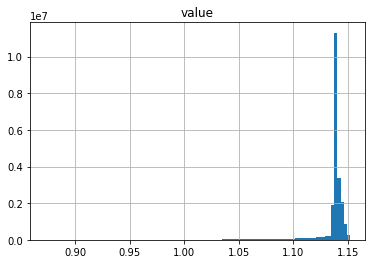

In [19]:
df.hist(column="value", bins=100)

In [20]:
df.to_csv("wind/PHL_air-density_150m.csv")

In [22]:
df.to_pickle("wind/PHL_air-density_150m.pkl")

In [ ]:
# lat change: 17.9083 to 17.9108 = 0.0025
# long change: 120.8472 to 120.8497 = 0.0025

In [39]:
import rasterio
import numpy as np
from affine import Affine
from pyproj import Proj, transform

In [43]:
fname = tif_file_name

# Read raster
with rasterio.open(fname) as r:
    T0 = r.transform  # upper-left pixel corner affine transform
    p1 = Proj(r.crs)
    A = r.read()  # pixel values

# All rows and columns
cols, rows = np.meshgrid(np.arange(A.shape[2]), np.arange(A.shape[1]))

# Get affine transform for pixel centres
T1 = T0 * Affine.translation(0.5, 0.5)
# Function to convert pixel row/column index (from 0) to easting/northing at centre
rc2en = lambda r, c: T1 * (c, r)

# All eastings and northings (there is probably a faster way to do this)
eastings, northings = np.vectorize(rc2en, otypes=[np.float, np.float])(rows, cols)

# Project all longitudes, latitudes
p2 = Proj(proj='latlong', datum='WGS84')
longs, lats = transform(p1, p2, eastings, northings)

<ipython-input-43-8f4d8a1f1edb>:15: DeprecationWarning: Right multiplication will be prohibited in version 3.0
  rc2en = lambda r, c: (c, r) * T1
<ipython-input-43-8f4d8a1f1edb>:22: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  longs, lats = transform(p1, p2, eastings, northings)


In [44]:
print(len(longs)), print(len(lats))

7671
7671


(None, None)

In [48]:
len(longs[0]), len(lats[0])

(5561, 5561)

In [51]:
lats[9][2997], longs[9][2997]

(123.5353226821997, 22.154518747734258)

In [52]:
longs[2997][9], lats[2997][9]

(14.684518747733886, 116.06532268219934)